# Autoencoder Example
## Chris Tralie

This code goes through an example of a convolutional autoencoder use to create an unsupervised embedding of the mnist digits (though the autoencoder class is setup to model any images with dimensions evenly divisible by 4)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.reshape(x_train, tuple(list(x_train.shape) + [1]))
x_train = np.array(x_train, dtype=float)/255
x_test = np.array(x_test, dtype=float)/255
x_test = np.reshape(x_test, tuple(list(x_test.shape) + [1]))

In [3]:
# Setup model
class AutoencoderCNN(Model):
    def __init__(self, imgres, d, k):
        """
        Parameters
        ----------
        imgres: int
            Resolution of each grayscale image
        d: int
            Dimension of the embedding
        k: int
            Kernel size at each layer
        """
        super(AutoencoderCNN, self).__init__()
        self.imgres = imgres
        self.d = d
        self.k = k
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(imgres, imgres, 1)),
            layers.Conv2D(8, (k, k), activation='relu', padding='same', strides=2),
            layers.Conv2D(16, (k, k), activation='relu', padding='same', strides=2),
            layers.Flatten(),
            layers.Dense(d, activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(d,)),
            layers.Dense(imgres**2),
            layers.Reshape((imgres//4, imgres//4, 16)),
            layers.Conv2DTranspose(16, kernel_size=k, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(8, kernel_size=k, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

imgres=28
autoencoder = AutoencoderCNN(imgres=imgres, d=2, k=3)
print(autoencoder.encoder.summary())
print(autoencoder.encoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1570      
Total params: 2,818
Trainable params: 2,818
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 8)         80        
_____________________________

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(x_train, x_train,
                #batch_size=20,
                epochs=10,
                shuffle=True,
                verbose=1,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0591 - val_loss: 0.0516
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0501 - val_loss: 0.0491
Epoch 3/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0484 - val_loss: 0.0478
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0474 - val_loss: 0.0467
Epoch 5/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0468 - val_loss: 0.0465
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0463 - val_loss: 0.0459
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0460 - val_loss: 0.0458
Epoch 8/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0458 - val_loss: 0.0460
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0456 - val_loss: 0.0453
Epoch 10/10
1875/1875 [==============================] - 14s 8ms/step - l

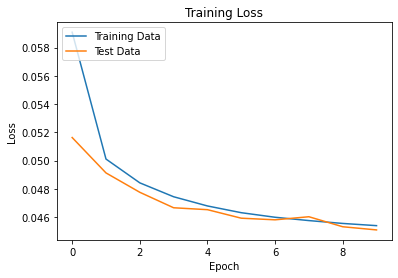

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Test Data'], loc='upper left')

(10000, 2)


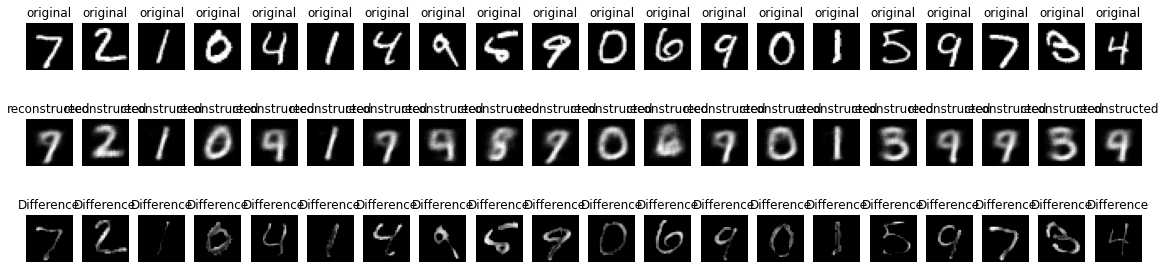

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
print(encoded_imgs.shape)
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 20
plt.figure(figsize=(20, 5))
for i in range(n):
    # display original
    plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title("original")
    plt.axis("off")

    # display reconstruction
    plt.subplot(3, n, n+i+1)
    plt.imshow(decoded_imgs[i], cmap='gray')
    plt.title("reconstructed")
    plt.axis("off")
    
    # display reconstruction
    plt.subplot(3, n, 2*n+i+1)
    plt.imshow(x_test[i] - decoded_imgs[i], cmap='gray', vmin=0, vmax=1)
    plt.title("Difference")
    plt.axis("off")
    

plt.show()

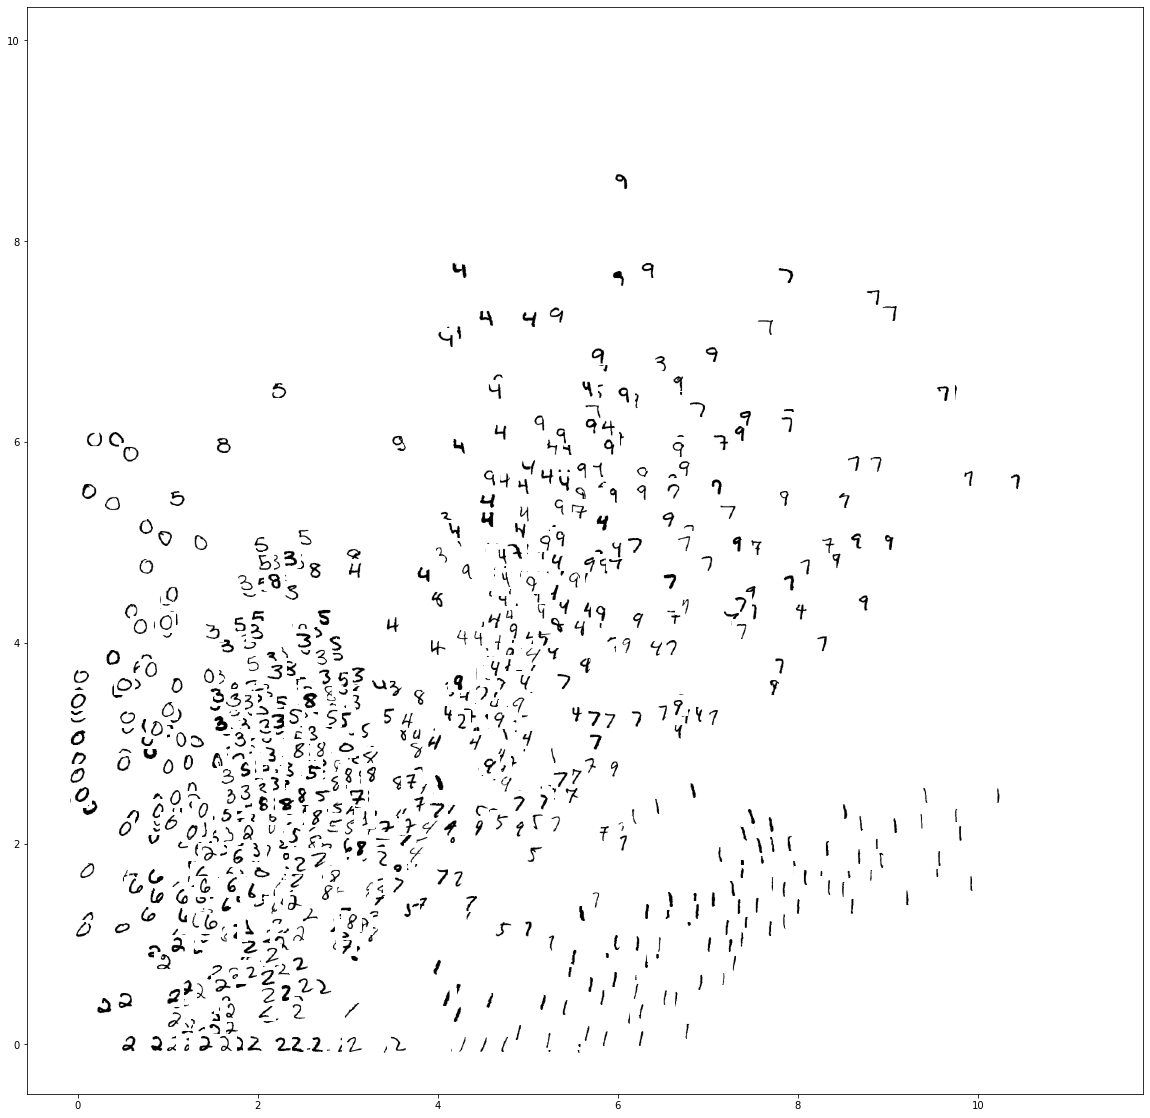

In [7]:
# Plot the first two coordinates of 1000 random encodings
plt.figure(figsize=(20, 20))
ax = plt.gca()
for idx in range(1000):
    img = np.reshape(x_test[idx, :, :, :], (imgres, imgres))
    img = OffsetImage(img, zoom=0.75, cmap='gray_r')
    x, y = encoded_imgs[idx, :]
    ab = AnnotationBbox(img, (x, y), xycoords='data', frameon=False)
    ax.add_artist(ab)
ax.update_datalim(encoded_imgs)
ax.autoscale()